<a href="https://colab.research.google.com/github/zhouchun0105/BA810_Team1/blob/main/SUBMIT_Bitcoin_Price_and_Movement_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price and Movement Direction Prediction**

Team 1, Morning Session

Chun Zhou, Geech Huot, Ji Qi, Vaibhav Garimella Bhaskara, Yihan Jia, Zheming Xu

# **Data Souces**

The dataset is scraped by Dr. Mark Zielinski (Brandeis University) from bitstamp

https://www.bitstamp.net/?gclid=CjwKCAjw4qCKBhAVEiwAkTYsPNsiJrj6svNLLPy3HMEyoxVQTQeWObFBVSOFJxZ2CP1yabYZTBv7JhoCgfoQAvD_BwE

Kaggle url(for data download): https://www.kaggle.com/mczielinski/bitcoin-historical-data


# **Project Objective**

Our goal is to predict bitcoin movement direction and exact price at a certain time. We will perform exploratory data analysis of bitcoin price time series from 2012 to 2021 with 16 attributes and 5 million rows. We will predict bitcoin price movement direction using logistics regression and predict bitcoin numerical price using ARIMA, LSTM and RNN models.


# **Import Packages**

In [ ]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 97 kB 2.5 MB/s 


In [ ]:
import os

import numpy as np
import pandas as pd

pd.set_option('mode.chained_assignment', None)
pd.set_option("display.max_columns", 100)

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import datetime as datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
os.listdir()

['.config', 'sample_data']

#**Data Cleaning**

Import dataset

In [ ]:
from google.colab import drive 
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/bitcoin.csv")

Change the timestamp to datetime attribute and turn the interval into seconds.

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
df = df.set_index('Timestamp')
df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


Analyze where the missing values are.

In [ ]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

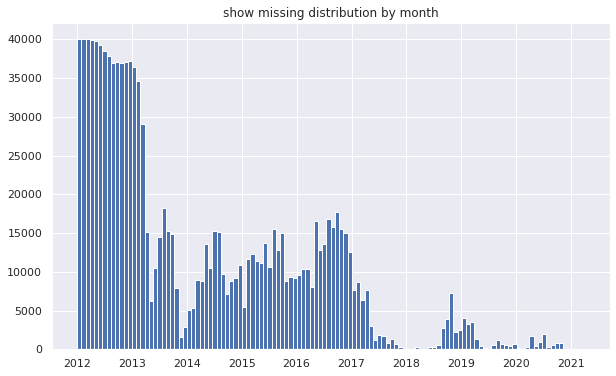

In [ ]:
plt.hist(rows_with_NaN.index,bins=120)
plt.title("show missing distribution by month")
plt.show()

Missing values from 2012 to 2013 is severe and 2014 to 2017 is moderate.

Spot the missing values

In [ ]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]
missed

,column,percent
0,Open,25.6
1,High,25.6
2,Low,25.6
3,Close,25.6
4,Volume_(BTC),25.6
5,Volume_(Currency),25.6
6,Weighted_Price,25.6


In [ ]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
is_NaN.index = is_NaN.index.year

All columns have the same percentage of missing values. This shows that probably missing values are in the same rows.

Further more analysis of missing data by year

In [ ]:
missing_by_yr = is_NaN.groupby(is_NaN.index).Open.agg('sum').to_frame().join(is_NaN.index.value_counts().to_frame())
missing_by_yr.columns=["Missing_counts", "Total_counts"]
missing_by_yr["Missing rate"] = missing_by_yr.Missing_counts/missing_by_yr.Total_counts
missing_by_yr

,Missing_counts,Total_counts,Missing rate
Timestamp,,,
2011,964,968,0.995868
2012,500411,527040,0.949474
2013,205839,525600,0.391627
2014,127424,525600,0.242435
2015,146393,519128,0.281998
2016,174941,527040,0.331931
2017,42268,525600,0.080419
2018,19827,525600,0.037723
2019,17260,525600,0.032839


Use interpolation to fill missing values.

In [ ]:
def fill_missing(df):
    frame = df.copy(deep=True)
    ### function to impute missing values using interpolation ###
    frame['Open'] = frame['Open'].interpolate()
    frame['Close'] = frame['Close'].interpolate()
    frame['Weighted_Price'] = frame['Weighted_Price'].interpolate()
    frame['Volume_(BTC)'] = frame['Volume_(BTC)'].interpolate()
    frame['Volume_(Currency)'] = frame['Volume_(Currency)'].interpolate()
    frame['High'] = frame['High'].interpolate()
    frame['Low'] = frame['Low'].interpolate()
    return frame


df_inter = fill_missing(df)
df_inter.dropna(inplace=True)
df.dropna(inplace=True)

In [ ]:
print('Orignal dataframe shape is: ' + str(df.shape))
print('Interpolated dataframe shape is: '+ str(df_inter.shape))

Orignal dataframe shape is: (3613769, 7)
Interpolated dataframe shape is: (4857377, 7)


Visualization of bitcoin price move and missing rate over time.

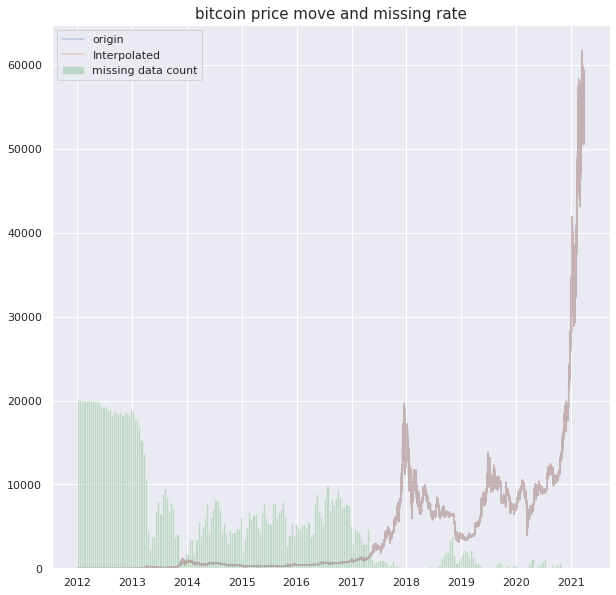

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(df.index, df.Weighted_Price, alpha= 0.3, label='origin')
ax.plot(df_inter.index, df_inter.Weighted_Price, alpha= 0.3, label='Interpolated')
ax.hist(rows_with_NaN.index,bins=240, alpha=0.3, label='missing data count')
ax.legend()
ax.set_title('bitcoin price move and missing rate', fontsize=15)
plt.show()

# **Feature Engineering**

Add a Price column to the dataframe by taking average of Open, High, Low, and Close price columns.

In [ ]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)


Add Return Column by calculating the difference from now to previous second's Price

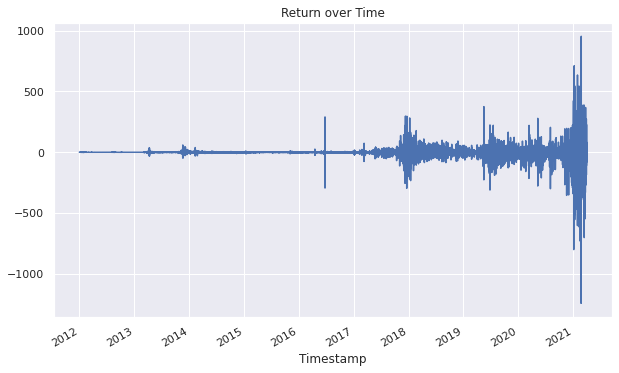

In [ ]:
df["Return"] = df["Price"].diff()
df["Return"].plot(x="Timestamp", y="Return", title="Return over Time")

We can see from the graph that the return fluctuation is the biggest in recent years. We believe that this is due to event driven factors such as Elon Musk's twitter and news on bitcoin over the internet.

Add Direction column showing if bitcoin price is going up or down.

In [ ]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

Add Percentage_Return column to show the perentage return per minutes. We can tell from the graph that there are abnormal values. Usually in-day return is controlled under 10% for stock markets.

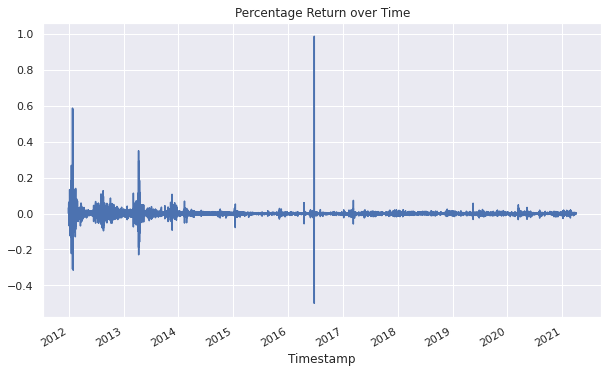

In [ ]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Percentage_Return"].plot(title="Percentage Return over Time")

The percentage return has more fluctuation in earlier years than recent's.

We decide to delete the abnormal values at 1% and 99% because the percentage return per minutes are not expected to be that high. We consider it as weird outliers.

In [ ]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Volume_diff"] = df["Volume_(Currency)"].diff()
df["Percentage_Volume"] = ((df["Volume_diff"].shift(periods=-1))/ (df["Price"])).shift(periods=1)

In [ ]:
low, high = 0.01, 0.99
selected_columns = ["Percentage_Return", "Percentage_Volume"]

quant_df = df[selected_columns].quantile([low, high])
quant_df

,Percentage_Return,Percentage_Volume
0.01,-0.004313,-83.656998
0.99,0.004219,85.030174


In [ ]:
low, high = 0.01, 0.99
selected_columns = ["Percentage_Return"]

quant_df = df[selected_columns].quantile([low, high])

for col in selected_columns:
    df.drop(df[df[col] <= quant_df.loc[low, col]].index, axis=0, inplace=True)
    df.drop(df[df[col] >= quant_df.loc[high, col]].index, axis=0, inplace=True)

Take a look at Percentage_Return image after we remove the abnormal values.

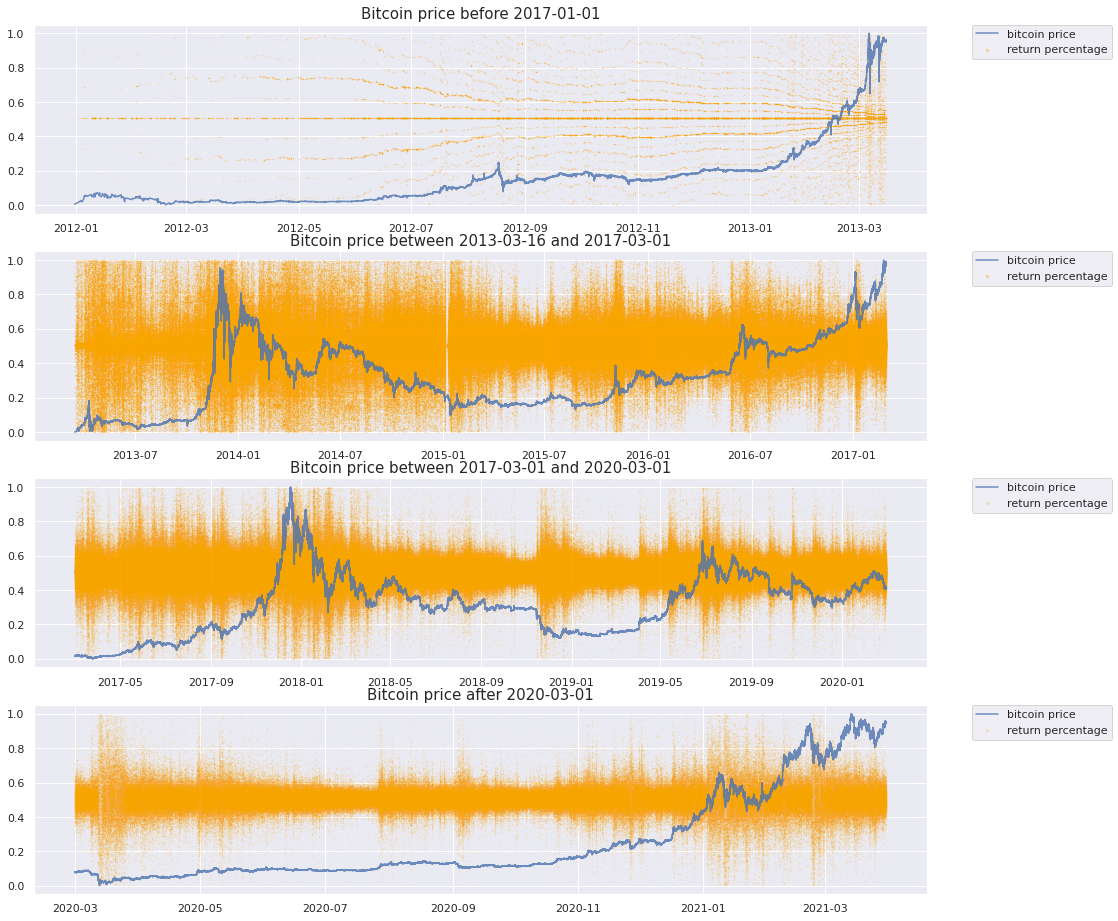

In [ ]:
# Choose the time interval
stamp1 = pd.Timestamp(2013,3,16)
stamp2 = pd.Timestamp(2017,3,1)
stamp3 = pd.Timestamp(2020,3,1)

# Enlarge the label font size
plt.rcParams.update({'font.size': 10})

# Plot the graph
fig, ax = plt.subplots(4, 1,figsize=(16,16))

time_stamp = pd.Timestamp(2017,1,1)
ax[0].plot(df[df.index<stamp1].index, scaler.fit_transform(df[df.index<stamp1].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[0].scatter(df[df.index<stamp1].index, scaler.fit_transform(df[df.index<stamp1].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.3, label="return percentage")
ax[0].set_title("Bitcoin price before %s"%time_stamp.strftime('%Y-%m-%d'), fontsize=15)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)


ax[1].plot(df[(df.index>stamp1)&(df.index<stamp2)].index, scaler.fit_transform(df[(df.index>stamp1)&(df.index<stamp2)].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[1].scatter(df[(df.index>stamp1)&(df.index<stamp2)].index, scaler.fit_transform(df[(df.index>stamp1)&(df.index<stamp2)].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.3, label="return percentage")
ax[1].set_title("Bitcoin price between %s and %s"%(stamp1.strftime('%Y-%m-%d'), stamp2.strftime('%Y-%m-%d')), fontsize=15)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)


ax[2].plot(df[(df.index>stamp2)&(df.index<stamp3)].index, scaler.fit_transform(df[(df.index>stamp2)&(df.index<stamp3)].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[2].scatter(df[(df.index>stamp2)&(df.index<stamp3)].index, scaler.fit_transform(df[(df.index>stamp2)&(df.index<stamp3)].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.2, label="return percentage")
ax[2].set_title("Bitcoin price between %s and %s"%(stamp2.strftime('%Y-%m-%d'), stamp3.strftime('%Y-%m-%d')), fontsize=15)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)


ax[3].plot(df[df.index>stamp3].index, scaler.fit_transform(df[df.index>stamp3].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[3].scatter(df[df.index>stamp3].index, scaler.fit_transform(df[df.index>stamp3].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.2, label="return percentage")
ax[3].set_title("Bitcoin price after %s"%(stamp3.strftime('%Y-%m-%d')), fontsize=15)
ax[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)

plt.draw()

Since we removed some abnormal values from the orignal dataset, the granularity is changed. We confirmed this change will not greatly affect our training model that learns from historical data with different time intervals. In general, the variance is stable over time for both graphs.

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [ ]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)

# **Exploratory Data Analysis**

Take a overview on how each attribute varies over time. From the graph, we can tell all the attributes increase over years and boost since 2020.

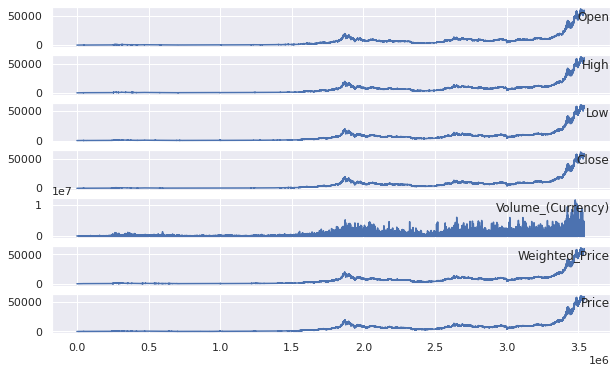

In [ ]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
plt.title("Attributes over Time")
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

Kernal Density Estimate plot of Price shows the approximate distribution of bitcoin prices. We can tell that most Price values are between 0 and 10 thousands USD.

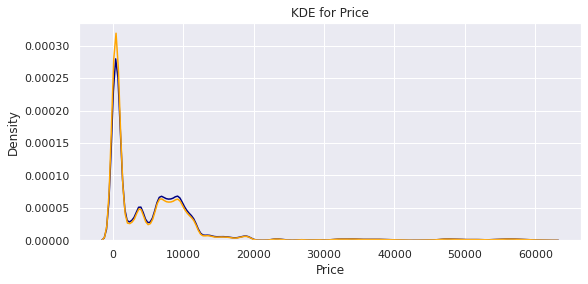

In [ ]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Direction'] == 'Up'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Direction'] == 'Down'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('Price')

Analyze correlations with seaborn heatmap

Each square shows the correlation between the variables on each axis.The close to 1 the correlation is the more positively correlated they are. As we can see in the graph those which are green, they have a perfect correlation, such as price and open price. For open price and volume(BTC),it has a negative correlation which means if one increase, one will decrease.

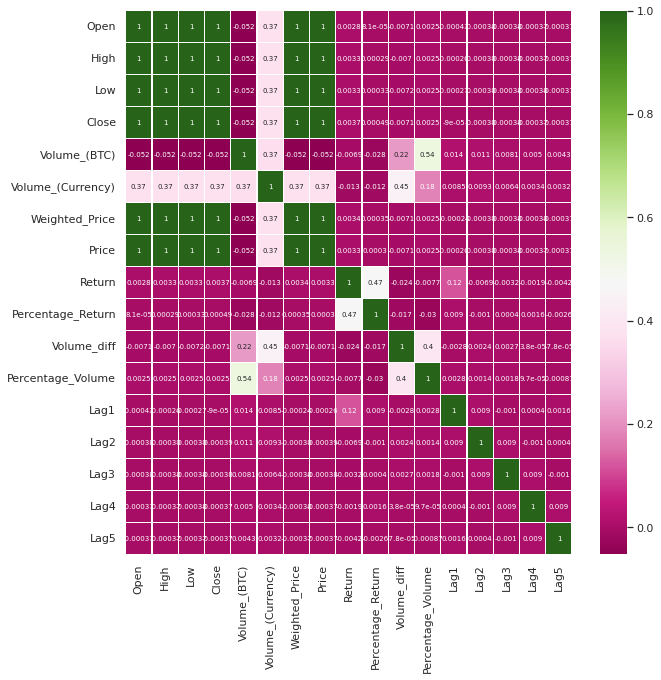

In [ ]:
corr = df.corr()
plt.figure(figsize=[10,10])
plt.rcParams['font.size']=7
sns.heatmap(corr, cmap='PiYG', annot= True, linewidths=0.3 );


Histogram, boxplot and violin plot showing the distribution of opening price. From the graph we can see the opening price has reached a price close to $17,000. Any price beyond \$17000 counts as outliers because it happened not much. In most cases, the opening price will not exceed \$7000. But normally, the opening price of bitcoin is around \$1000. So we can tell that Bitcoin's opening price fluctuates very much,and most of them are sold at low prices.

In [ ]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


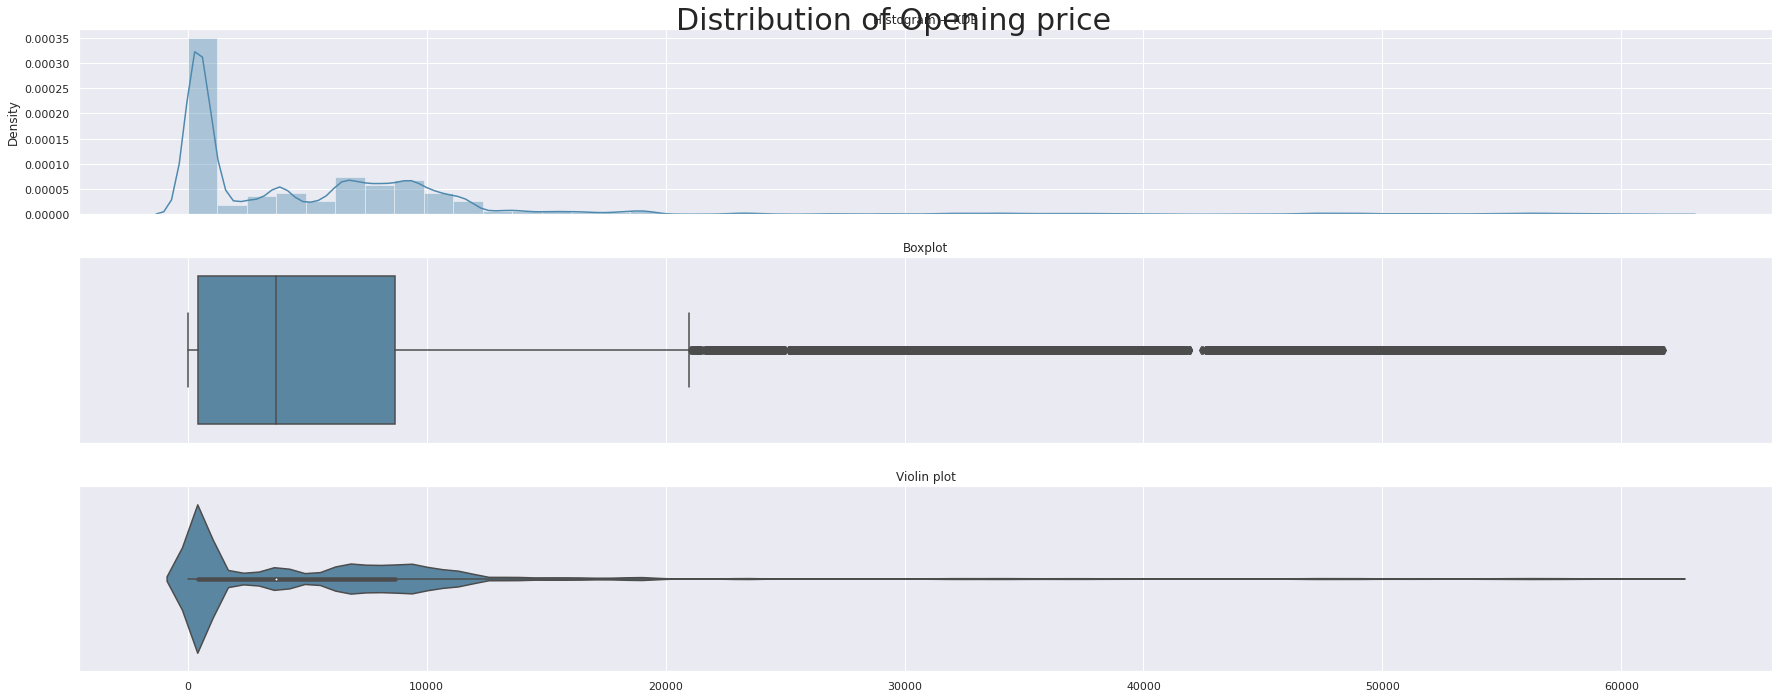

In [ ]:
triple_plot(df['Open'],'Distribution of Opening price',custom_colors[0])

We want to analyze if lagged time series will help to predict current bitcoin price. If there is a linear relationship, the prediction will work well.

We can see that there is a positive correlation for minute, hour and daily lag plots. We observe absolutely no correlation for month lag plots.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

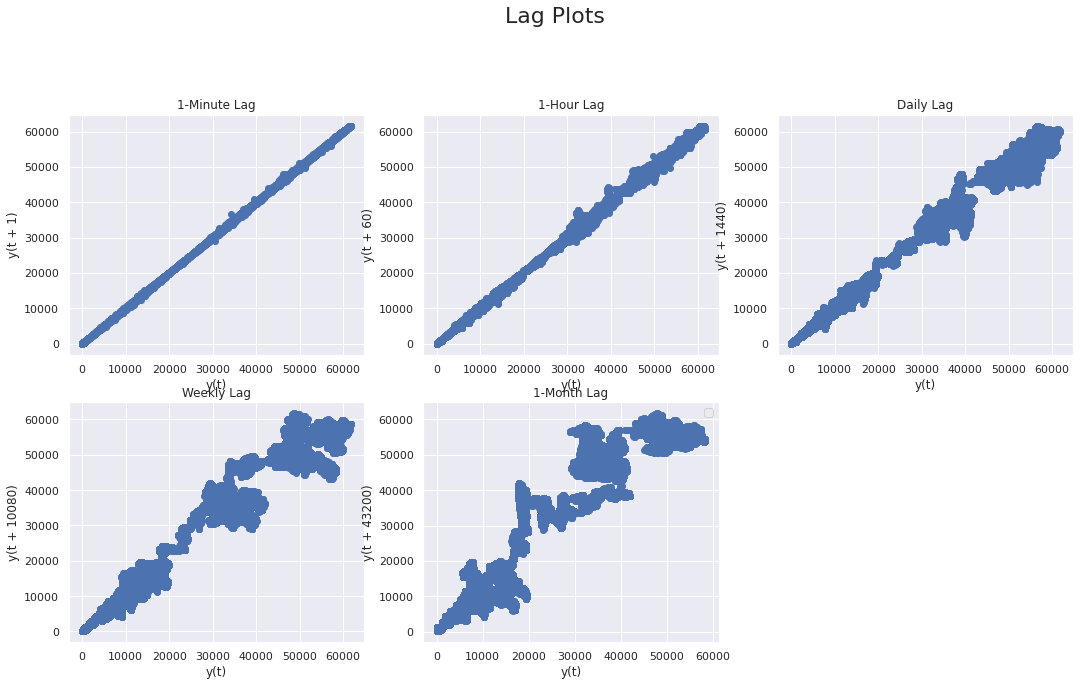

In [ ]:
plt.figure(figsize=(18,15))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(df['Weighted_Price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(df['Weighted_Price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(df['Weighted_Price'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(df['Weighted_Price'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(df['Weighted_Price'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

In [ ]:
df_new = df[df.columns[:8]]
# Resampling to half day frequency
df_D = df_new.resample('12H').mean()

In [ ]:
# Resampling to half day frequency
df_D = df_new.resample('12H').mean()

# Resampling to weekly frequency
df_W = df_new.resample('W').mean()

# Resampling to quarterly frequency
df_month = df.resample('3M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

In [ ]:
def fill_missing(df_D):
    ### function to impute missing values using interpolation ###
    df_D['Open'] = df_D['Open'].interpolate()
    df_D['Close'] = df_D['Close'].interpolate()
    df_D['High'] = df_D['High'].interpolate()
    df_D['Low'] = df_D['Low'].interpolate()
    df_D['Weighted_Price'] = df_D['Weighted_Price'].interpolate()
    df_D['Price'] = df_D['Price'].interpolate()
    df_D['Volume_(BTC)'] = df_D['Volume_(BTC)'].interpolate()
    df_D['Volume_(Currency)'] = df_D['Volume_(Currency)'].interpolate()

fill_missing(df_D)
fill_missing(df_W)
fill_missing(df_month)
fill_missing(df_year)

In [ ]:
df_D.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6757 entries, 2011-12-31 00:00:00 to 2021-03-31 00:00:00
Freq: 12H
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               6757 non-null   float64
 1   High               6757 non-null   float64
 2   Low                6757 non-null   float64
 3   Close              6757 non-null   float64
 4   Volume_(BTC)       6757 non-null   float64
 5   Volume_(Currency)  6757 non-null   float64
 6   Weighted_Price     6757 non-null   float64
 7   Price              6757 non-null   float64
dtypes: float64(8)
memory usage: 475.1 KB


Check the average price of each month after 2016. Usually March and February have highest bitcoin prices.

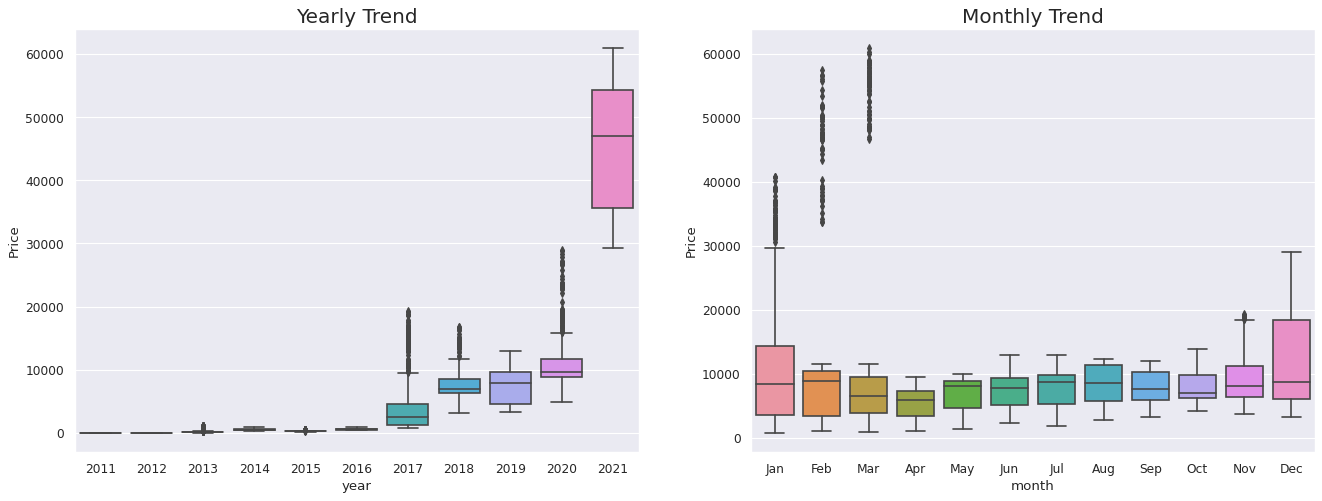

In [ ]:
df_D['year'] = [d.year for d in df_D.index]
df_D['month'] = [d.strftime('%b') for d in df_D.index]
years = df_D['year'].unique()


fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Price', data=df_D, ax = axes[0])  
sns.boxplot(x='month', y='Price', data=df_D.loc[df_D.year.isin(list(range(2017,2022)))], ax= axes[1])


axes[0].set_title('Yearly Trend', fontsize=18); 
axes[1].set_title('Monthly Trend', fontsize=18);

In [ ]:
df_D[df_D['year'] > 2016].groupby('month').Price.mean().sort_values(ascending = False)

month
Mar    14988.888932
Feb    13935.280757
Jan    12070.177134
Dec    11893.472123
Nov     9505.120605
Aug     8192.041344
Oct     7975.727248
Sep     7780.207449
Jul     7451.283937
Jun     7055.918113
May     6695.697963
Apr     5377.923475
Name: Price, dtype: float64

According to the above two boxplots, the left one shows the yearly trend of the 
bitcoins price, and we can see that from 2011 to 2016, the price almost had no change. Since 2017, the price started to increase and there was a rapid growth from 2020 to 2021. In addition, the maximum fluctutations in prices occurred in 2021.

From the right plot, the highest mean value happened at the first quarter of the year and the lowest mean value appeared at the fourth quarter of each year. In addition, there were more outliers which was way higher than the mean values of each month appeared during the first quarter.

# **Lotistics Regression**

Half Day Price Prediction Using Logistic Regression

In [ ]:
df_D.loc[:, 'Next_Price'] = df_D['Price'].shift(-1)

df_D.loc[(df_D['Price'] > df_D['Next_Price']), 'Trend'] = 0
df_D.loc[(df_D['Price'] < df_D['Next_Price']), 'Trend'] = 1

df_D.drop(df.index[-1], axis=0, inplace=True) 

Clear NaN for df_D

In [ ]:
def fill_missing(df_D):
    ### function to impute missing values using interpolation ###
    df_D['Open'] = df_D['Open'].interpolate()
    df_D['Close'] = df_D['Close'].interpolate()
    df_D['High'] = df_D['High'].interpolate()
    df_D['Low'] = df_D['Low'].interpolate()
    df_D['Weighted_Price'] = df_D['Weighted_Price'].interpolate()
    df_D['Price'] = df_D['Price'].interpolate()
    df_D['Volume_(BTC)'] = df_D['Volume_(BTC)'].interpolate()
    df_D['Volume_(Currency)'] = df_D['Volume_(Currency)'].interpolate()

fill_missing(df_D)
fill_missing(df_W)
fill_missing(df_month)
fill_missing(df_year)

Define variables.

In [ ]:
# Predictor X
X = df_D.drop(["Trend", 'Volume_(BTC)', 'Weighted_Price','Next_Price'],  axis = 1)
X.shape

(6756, 8)

In [ ]:
# Response y
y = df_D['Trend']
y.shape

(6756,)

In [ ]:
# Split the test and train sets 
# Use a 20% split for test.
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=888)

In [ ]:
len(Xtrain), len(Xtest), len(ytrain), len(ytest)

(5404, 1352, 5404, 1352)

In [ ]:
from sklearn.linear_model import LogisticRegression   # choose model class
model = LogisticRegression(solver='liblinear')       # instantiate model

In [ ]:
# Fit model to the training data:
model.fit(Xtrain, ytrain)

ValueError: ignored

In [ ]:
# Predict the test set
y_model = model.predict(Xtest)

NotFittedError: ignored

In [ ]:
test = Xtest.join(ytest).reset_index()
test.join(pd.Series(y_model, name = 'predicted trend')).sort_values('Timestamp').reset_index().drop('index', axis = 1)

NameError: ignored

In [ ]:
# Check the accuracy of this model
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

In [ ]:
sum(y_model == ytest) / len(ytest)

In [ ]:
model.score(Xtest, ytest)

In [ ]:
from sklearn.naive_bayes import GaussianNB
model_g = GaussianNB()
model_g.fit(Xtrain, ytrain)
y_model_g = model_g.predict(Xtest)

In [ ]:
Xtest = Xtest.join(ytest, sort = True).reset_index()
Xtest.join(pd.Series(y_model_g, name = 'predicted_trend'))

In [ ]:
sum(y_model_g == ytest) / len(ytest)

Our gaussian naive bayes model shows the model accuracy at 53%, which is slightly lower than the Logistic Regression model.

However, these two models are not good enough to predict the bitcoins price, since they don't capture any other impacts such as, seasonality, trend, and intrinsic factors.

# **ARIMA Model**